In [1]:
import sys
sys.path.insert(0, './ml')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, plot_roc_curve
from sklearn.preprocessing import StandardScaler

from ml.gs_rf import grid_search
from ml.SVM_RF import run as run_model
from ml import ML_util

from features.spatial_features_calc import get_spatial_features_names
from features.morphological_features_calc import get_morphological_features_names
from features.temporal_features_calc import get_temporal_features_names

In [2]:
chunks = [0, 500, 200]
modalities = ['spatial', 'morphological', 'temporal', 'spat_tempo']
restrictions = ['complete', 'no_small_sample']

n_estimators_min = 0
n_estimators_max = 2
n_estimators_num = 3
max_depth_min = 1
max_depth_max = 2
max_depth_num = 2
min_samples_splits_min = 1
min_samples_splits_max = 5
min_samples_splits_num = 5
min_samples_leafs_min = 0
min_samples_leafs_max = 5
min_samples_leafs_num = 6
n = 10

In [3]:
def calc_auc(clf, data_path):
    train, dev, test, _, _, _ = ML_util.get_dataset(data_path)
    train = np.concatenate((train, dev))
    train_squeezed = ML_util.squeeze_clusters(train)
    train_features, train_labels = ML_util.split_features(train_squeezed)
    
    scaler = StandardScaler()
    scaler.fit(train_features)
    train_features = scaler.transform(train_features)
    
    preds = []
    targets = []
    
    for cluster in test:
        features, labels = ML_util.split_features(cluster)
        features = np.nan_to_num(features)
        features = scaler.transform(features)
        label = labels[0]  # as they are the same for all the cluster
        pred = clf.predict_proba(features).mean(axis=0)[1]
        preds.append(pred)
        targets.append(label)
    
    fpr, tpr, thresholds = roc_curve(targets, preds)  # calculate fpr and tpr values for different thresholds
    auc_val = auc(fpr, tpr)
        
    return auc_val

def get_modality_results(data_path):
    accs, pyr_accs, in_accs, aucs = [], [], [], []
    
    clf, acc, pyr_acc, in_acc, n_estimators, max_depth, min_samples_split, min_samples_leaf = grid_search(
        data_path + "/0_0.60.20.2/", False, n_estimators_min, n_estimators_max, n_estimators_num,
        max_depth_min, max_depth_max, max_depth_num, min_samples_splits_min, min_samples_splits_max,
        min_samples_splits_num, min_samples_leafs_min, min_samples_leafs_max, min_samples_leafs_num, n)
    auc = calc_auc(clf, data_path + "/0_0.60.20.2/")
    
    accs.append(acc)
    pyr_accs.append(pyr_acc)
    in_accs.append(in_acc)
    aucs.append(auc)
    
    restriction, modality = data_path.split('/')[-2:]
    
    if modality == 'temporal':
        accs = accs * len(chunks)
        pyr_accs = pyr_accs * len(chunks)
        in_accs = in_accs * len(chunks)
        aucs = aucs * len(chunks)
    else:
        for chunk_size in chunks[1:]:
            clf, acc, pyr_acc, in_acc = run_model('rf', None, None, None, False, None, False, True, False, None, None, None,
                n_estimators, max_depth, min_samples_split, min_samples_leaf, data_path + f"/{chunk_size}_0.60.20.2/")
            auc = calc_auc(clf, data_path + f"/{chunk_size}_0.60.20.2/")
            
            accs.append(acc)
            pyr_accs.append(pyr_acc)
            in_accs.append(in_acc)
            aucs.append(auc)
        
    df = pd.DataFrame({'restriction': restriction, 'modality': modality, 'chunk_size': chunks,
                           'acc': accs, 'pyr_acc': pyr_accs, 'in_acc': in_accs, 'auc': aucs})
    
    return df
                                       
def get_folder_results(data_path):
    df = pd.DataFrame({'restriction': [], 'modality': [], 'chunk_size': [], 'acc': [], 'pyr_acc': [], 'in_acc': [], 'auc': []})
    for modality in modalities:
        modaility_df = get_modality_results(data_path + '/' + modality)
        df = df.append(modaility_df, ignore_index=True)
        
    return df

def get_results(data_path):
    df = pd.DataFrame({'restriction': [], 'modality': [], 'chunk_size': [], 'acc': [], 'pyr_acc': [], 'in_acc': [], 'auc': []})
    for restriction in restrictions:
        folder_df = get_folder_results(data_path + '/' + restriction)
        df = df.append(folder_df, ignore_index=True)
        
    return df    

In [4]:
results = get_results('./data_sets')

Loading data set from ./data_sets/complete/spatial/0_0.60.20.2/...
Total number of clusters in train data is 306 (59.766%) consisting of 306 waveforms (59.766%)
Total number of pyramidal clusters in train data is 246 (80.392%) consisting of 246 waveforms (80.392%)
Total number of interneurons clusters in train data is 60 (19.608%) consisting of 60 waveforms (19.608%)
Total number of untagged clusters in train data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in dev data is 102 (19.922%) consisting of 102 waveforms (19.922%)
Total number of pyramidal clusters in dev data is 82 (80.392%) consisting of 82 waveforms (80.392%)
Total number of interneurons clusters in dev data is 20 (19.608%) consisting of 20 waveforms (19.608%)
Total number of untagged clusters in dev data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in test data is 104 (20.312%) consisting of 104 waveforms (20.312%)
Total number of pyramidal clusters in test data is

Loading data set from ./data_sets/complete/morphological/0_0.60.20.2/...
Total number of clusters in train data is 306 (59.766%) consisting of 306 waveforms (59.766%)
Total number of pyramidal clusters in train data is 246 (80.392%) consisting of 246 waveforms (80.392%)
Total number of interneurons clusters in train data is 60 (19.608%) consisting of 60 waveforms (19.608%)
Total number of untagged clusters in train data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in dev data is 102 (19.922%) consisting of 102 waveforms (19.922%)
Total number of pyramidal clusters in dev data is 82 (80.392%) consisting of 82 waveforms (80.392%)
Total number of interneurons clusters in dev data is 20 (19.608%) consisting of 20 waveforms (19.608%)
Total number of untagged clusters in dev data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in test data is 104 (20.312%) consisting of 104 waveforms (20.312%)
Total number of pyramidal clusters in test d

Loading data set from ./data_sets/complete/temporal/0_0.60.20.2/...
Total number of clusters in train data is 306 (59.766%) consisting of 306 waveforms (59.766%)
Total number of pyramidal clusters in train data is 246 (80.392%) consisting of 246 waveforms (80.392%)
Total number of interneurons clusters in train data is 60 (19.608%) consisting of 60 waveforms (19.608%)
Total number of untagged clusters in train data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in dev data is 102 (19.922%) consisting of 102 waveforms (19.922%)
Total number of pyramidal clusters in dev data is 82 (80.392%) consisting of 82 waveforms (80.392%)
Total number of interneurons clusters in dev data is 20 (19.608%) consisting of 20 waveforms (19.608%)
Total number of untagged clusters in dev data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in test data is 104 (20.312%) consisting of 104 waveforms (20.312%)
Total number of pyramidal clusters in test data i

Chosen model is Random Forest
Loading data set from ./data_sets/complete/spat_tempo/200_0.60.20.2/...
Total number of clusters in train data is 306 (59.766%) consisting of 71270 waveforms (61.740%)
Total number of pyramidal clusters in train data is 246 (80.392%) consisting of 20067 waveforms (28.156%)
Total number of interneurons clusters in train data is 60 (19.608%) consisting of 51203 waveforms (71.844%)
Total number of untagged clusters in train data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in dev data is 102 (19.922%) consisting of 16465 waveforms (14.263%)
Total number of pyramidal clusters in dev data is 82 (80.392%) consisting of 6725 waveforms (40.844%)
Total number of interneurons clusters in dev data is 20 (19.608%) consisting of 9740 waveforms (59.156%)
Total number of untagged clusters in dev data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in test data is 104 (20.312%) consisting of 27701 waveforms (23.997%)


Chosen model is Random Forest
Loading data set from ./data_sets/no_small_sample/spatial/200_0.60.20.2/...
Total number of clusters in train data is 202 (59.587%) consisting of 65305 waveforms (58.598%)
Total number of pyramidal clusters in train data is 148 (73.267%) consisting of 17040 waveforms (26.093%)
Total number of interneurons clusters in train data is 54 (26.733%) consisting of 48265 waveforms (73.907%)
Total number of untagged clusters in train data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in dev data is 68 (20.059%) consisting of 24244 waveforms (21.754%)
Total number of pyramidal clusters in dev data is 50 (73.529%) consisting of 6649 waveforms (27.425%)
Total number of interneurons clusters in dev data is 18 (26.471%) consisting of 17595 waveforms (72.575%)
Total number of untagged clusters in dev data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in test data is 69 (20.354%) consisting of 21896 waveforms (19.647

Chosen model is Random Forest
Loading data set from ./data_sets/no_small_sample/morphological/200_0.60.20.2/...
Total number of clusters in train data is 202 (59.587%) consisting of 65305 waveforms (58.598%)
Total number of pyramidal clusters in train data is 148 (73.267%) consisting of 17040 waveforms (26.093%)
Total number of interneurons clusters in train data is 54 (26.733%) consisting of 48265 waveforms (73.907%)
Total number of untagged clusters in train data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in dev data is 68 (20.059%) consisting of 24244 waveforms (21.754%)
Total number of pyramidal clusters in dev data is 50 (73.529%) consisting of 6649 waveforms (27.425%)
Total number of interneurons clusters in dev data is 18 (26.471%) consisting of 17595 waveforms (72.575%)
Total number of untagged clusters in dev data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in test data is 69 (20.354%) consisting of 21896 waveforms (

Chosen model is Random Forest
Loading data set from ./data_sets/no_small_sample/spat_tempo/500_0.60.20.2/...
Total number of clusters in train data is 202 (59.587%) consisting of 26056 waveforms (58.595%)
Total number of pyramidal clusters in train data is 148 (73.267%) consisting of 6767 waveforms (25.971%)
Total number of interneurons clusters in train data is 54 (26.733%) consisting of 19289 waveforms (74.029%)
Total number of untagged clusters in train data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in dev data is 68 (20.059%) consisting of 9678 waveforms (21.764%)
Total number of pyramidal clusters in dev data is 50 (73.529%) consisting of 2646 waveforms (27.340%)
Total number of interneurons clusters in dev data is 18 (26.471%) consisting of 7032 waveforms (72.660%)
Total number of untagged clusters in dev data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in test data is 69 (20.354%) consisting of 8734 waveforms (19.641%

In [5]:
print(results)

        restriction       modality  chunk_size         acc     pyr_acc  \
0          complete        spatial         0.0   86.538462   93.975904   
1          complete        spatial       500.0   81.730769   87.951807   
2          complete        spatial       200.0   86.538462   87.951807   
3          complete  morphological         0.0  100.000000  100.000000   
4          complete  morphological       500.0   99.038462  100.000000   
5          complete  morphological       200.0   99.038462  100.000000   
6          complete       temporal         0.0   88.461538   90.361446   
7          complete       temporal       500.0   88.461538   90.361446   
8          complete       temporal       200.0   88.461538   90.361446   
9          complete     spat_tempo         0.0   92.307692   92.771084   
10         complete     spat_tempo       500.0   91.346154   91.566265   
11         complete     spat_tempo       200.0   92.307692   92.771084   
12  no_small_sample        spatial    

In [6]:
results = results.set_index(['restriction', 'modality', 'chunk_size'], append=True)  # create multi-index

In [7]:
results.to_csv('results_for_report.csv')

In [8]:
results

,,,,acc,pyr_acc,in_acc,auc
,restriction,modality,chunk_size,,,,
0,complete,spatial,0.0,86.538462,93.975904,57.142857,0.917384
1,complete,spatial,500.0,81.730769,87.951807,57.142857,0.902467
2,complete,spatial,200.0,86.538462,87.951807,80.952381,0.930579
3,complete,morphological,0.0,100.000000,100.000000,100.000000,1.000000
4,complete,morphological,500.0,99.038462,100.000000,95.238095,1.000000
5,complete,morphological,200.0,99.038462,100.000000,95.238095,1.000000
6,complete,temporal,0.0,88.461538,90.361446,80.952381,0.958118
7,complete,temporal,500.0,88.461538,90.361446,80.952381,0.958118
8,complete,temporal,200.0,88.461538,90.361446,80.952381,0.958118


In [9]:
def get_num_cells(restriction):
    data_path = f"./data_sets/{restriction}/spatial/0_0.60.20.2/"
    train, dev, test, _, _, _ = ML_util.get_dataset(data_path)
    tot_n = len(train) + len(dev) + len(test)
    test_n = len(test)
    pyr_n = len([cell for cell in test if cell[0][-1] == 1])
    in_n = len([cell for cell in test if cell[0][-1] == 0])
    return tot_n, test_n, pyr_n, in_n

def autolabel(rects, ax):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    This function was taken from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
    """
    for rect in rects:
        height = rect.get_height()
        if height == 0:
            continue
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def plot_results(df, restriction, acc=True):
    tot_n, test_n, pyr_n, in_n = get_num_cells(restriction)
    
    labels = modalities
    
    if acc:
        zero = df.xs(0, level="chunk_size").acc
        five_hundred = df.xs(500, level="chunk_size").acc
        two_hundred = df.xs(200, level="chunk_size").acc
    else:
        zero = df.xs(0, level="chunk_size").auc
        five_hundred = df.xs(500, level="chunk_size").auc
        two_hundred = df.xs(200, level="chunk_size").auc

    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize = (12, 12))
    rects1 = ax.bar(x - width, zero, width, label='chunk_size = 0')
    rects2 = ax.bar(x, five_hundred, width, label='chunk_size = 500')
    rects3 = ax.bar(x + width, two_hundred, width, label='chunk_size = 200')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores (percentage)')
    ax.set_title(f"Scores by modality and chunk size; Total={tot_n}, Test={test_n}, PYR={pyr_n}, IN={in_n}")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    autolabel(rects1, ax)
    autolabel(rects2, ax)
    autolabel(rects3, ax)

    fig.tight_layout()

    plt.show()

Loading data set from ./data_sets/complete/spatial/0_0.60.20.2/...
Total number of clusters in train data is 306 (59.766%) consisting of 306 waveforms (59.766%)
Total number of pyramidal clusters in train data is 246 (80.392%) consisting of 246 waveforms (80.392%)
Total number of interneurons clusters in train data is 60 (19.608%) consisting of 60 waveforms (19.608%)
Total number of untagged clusters in train data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in dev data is 102 (19.922%) consisting of 102 waveforms (19.922%)
Total number of pyramidal clusters in dev data is 82 (80.392%) consisting of 82 waveforms (80.392%)
Total number of interneurons clusters in dev data is 20 (19.608%) consisting of 20 waveforms (19.608%)
Total number of untagged clusters in dev data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in test data is 104 (20.312%) consisting of 104 waveforms (20.312%)
Total number of pyramidal clusters in test data is

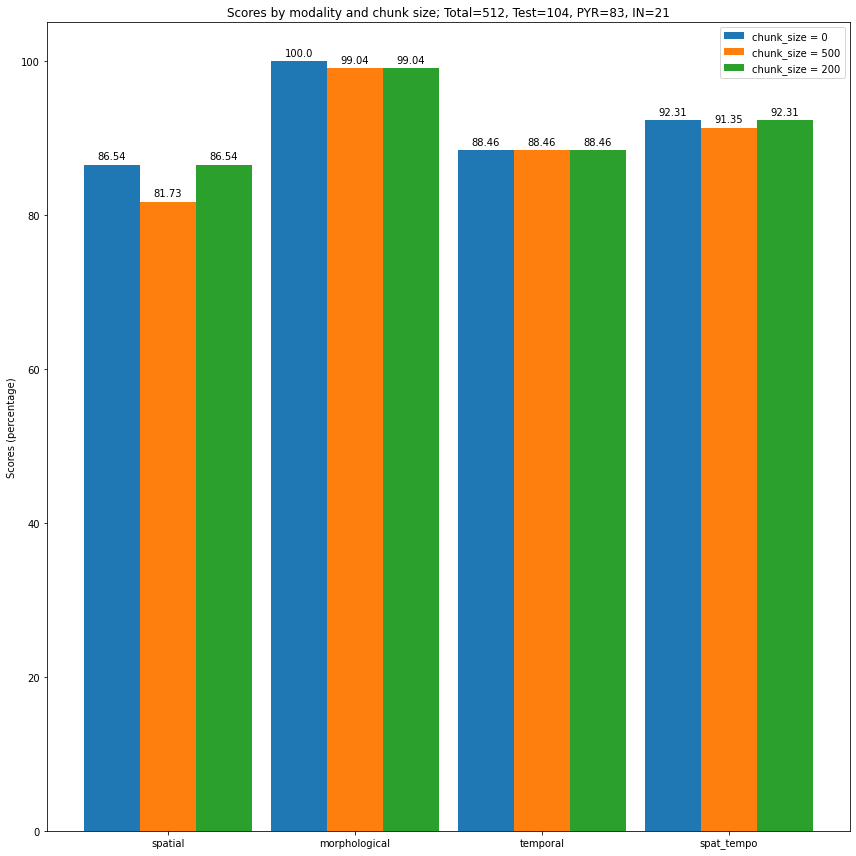

In [10]:
complete = results.loc[:, 'complete', :, :].drop(columns = ['pyr_acc', 'in_acc'])
plot_results(complete, 'complete')

Loading data set from ./data_sets/complete/spatial/0_0.60.20.2/...
Total number of clusters in train data is 306 (59.766%) consisting of 306 waveforms (59.766%)
Total number of pyramidal clusters in train data is 246 (80.392%) consisting of 246 waveforms (80.392%)
Total number of interneurons clusters in train data is 60 (19.608%) consisting of 60 waveforms (19.608%)
Total number of untagged clusters in train data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in dev data is 102 (19.922%) consisting of 102 waveforms (19.922%)
Total number of pyramidal clusters in dev data is 82 (80.392%) consisting of 82 waveforms (80.392%)
Total number of interneurons clusters in dev data is 20 (19.608%) consisting of 20 waveforms (19.608%)
Total number of untagged clusters in dev data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in test data is 104 (20.312%) consisting of 104 waveforms (20.312%)
Total number of pyramidal clusters in test data is

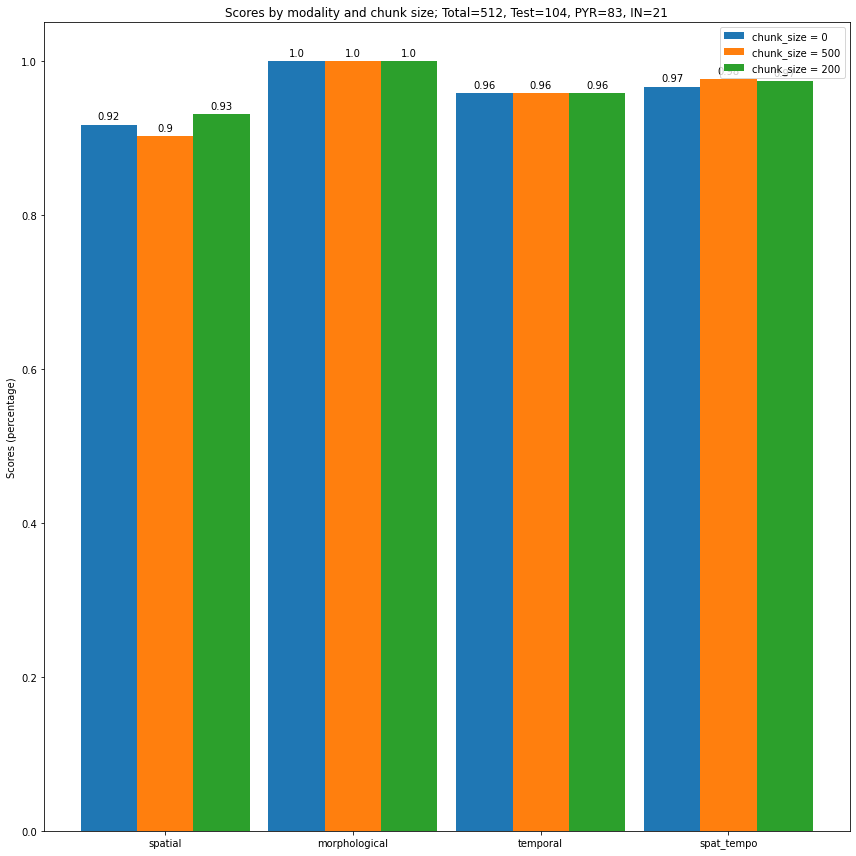

In [11]:
complete = results.loc[:, 'complete', :, :].drop(columns = ['pyr_acc', 'in_acc'])
plot_results(complete, 'complete', acc=False)

Loading data set from ./data_sets/no_small_sample/spatial/0_0.60.20.2/...
Total number of clusters in train data is 202 (59.587%) consisting of 202 waveforms (59.587%)
Total number of pyramidal clusters in train data is 148 (73.267%) consisting of 148 waveforms (73.267%)
Total number of interneurons clusters in train data is 54 (26.733%) consisting of 54 waveforms (26.733%)
Total number of untagged clusters in train data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in dev data is 68 (20.059%) consisting of 68 waveforms (20.059%)
Total number of pyramidal clusters in dev data is 50 (73.529%) consisting of 50 waveforms (73.529%)
Total number of interneurons clusters in dev data is 18 (26.471%) consisting of 18 waveforms (26.471%)
Total number of untagged clusters in dev data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in test data is 69 (20.354%) consisting of 69 waveforms (20.354%)
Total number of pyramidal clusters in test data

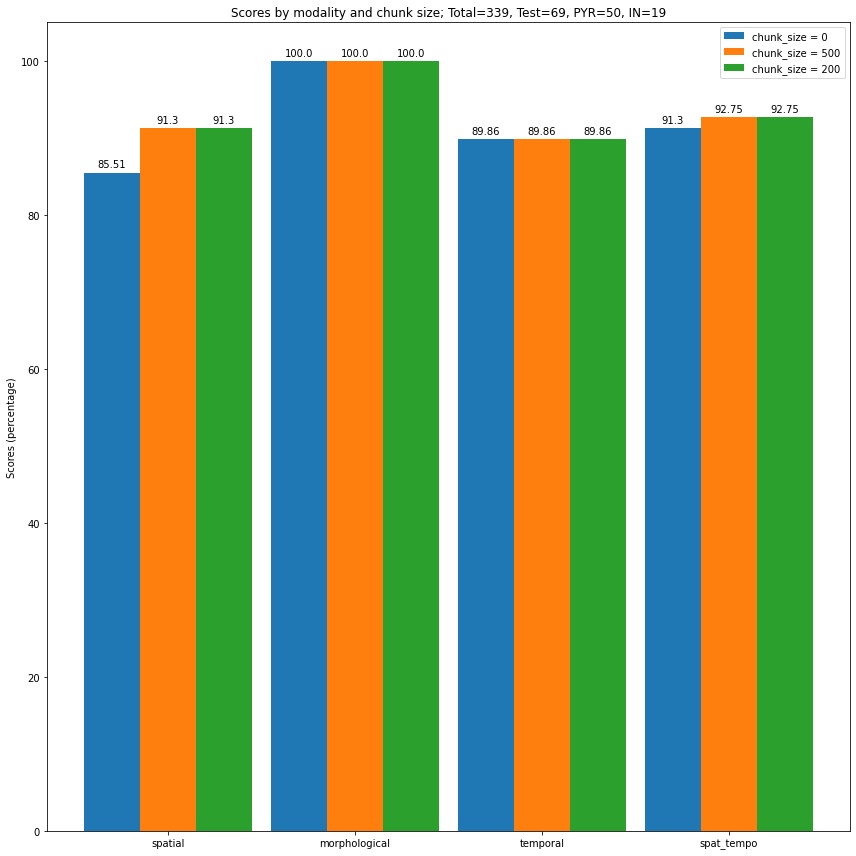

In [12]:
no_small_sample = results.loc[:, 'no_small_sample', :, :].drop(columns = ['pyr_acc', 'in_acc'])
plot_results(no_small_sample, 'no_small_sample')

Loading data set from ./data_sets/no_small_sample/spatial/0_0.60.20.2/...
Total number of clusters in train data is 202 (59.587%) consisting of 202 waveforms (59.587%)
Total number of pyramidal clusters in train data is 148 (73.267%) consisting of 148 waveforms (73.267%)
Total number of interneurons clusters in train data is 54 (26.733%) consisting of 54 waveforms (26.733%)
Total number of untagged clusters in train data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in dev data is 68 (20.059%) consisting of 68 waveforms (20.059%)
Total number of pyramidal clusters in dev data is 50 (73.529%) consisting of 50 waveforms (73.529%)
Total number of interneurons clusters in dev data is 18 (26.471%) consisting of 18 waveforms (26.471%)
Total number of untagged clusters in dev data is 0 (0.000%) consisting of 0 waveforms (0.000%)
Total number of clusters in test data is 69 (20.354%) consisting of 69 waveforms (20.354%)
Total number of pyramidal clusters in test data

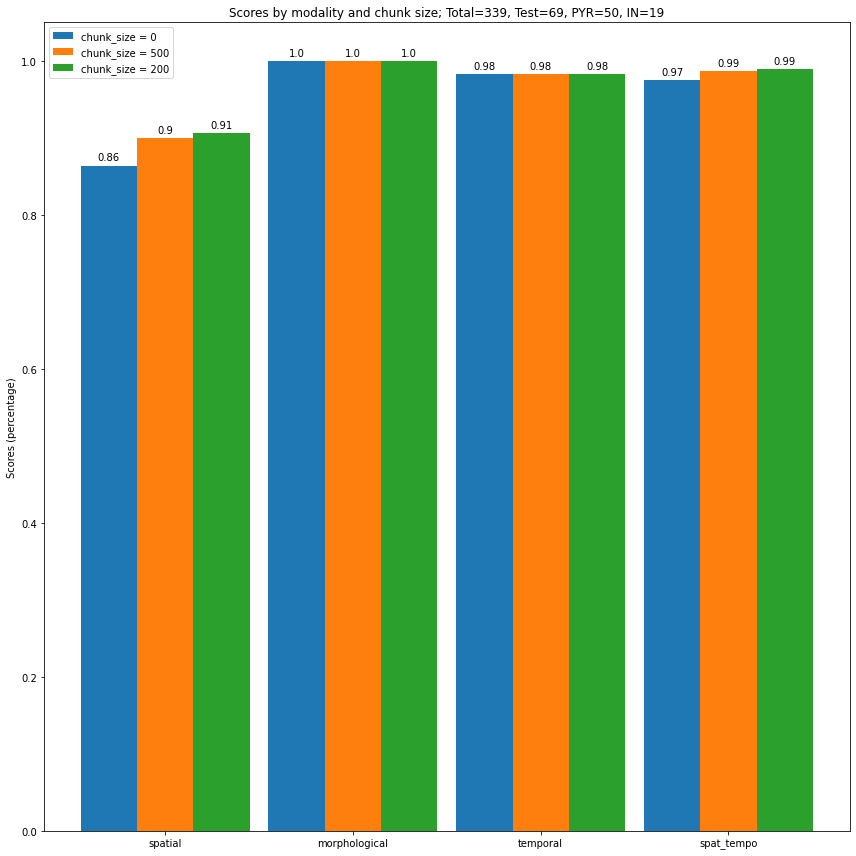

In [13]:
no_small_sample = results.loc[:, 'no_small_sample', :, :].drop(columns = ['pyr_acc', 'in_acc'])
plot_results(no_small_sample, 'no_small_sample', acc=False)